# Modeling - Resampling

Taking my best model (ADA with CountVectorizer) I will try different re-sampling techniques and evaluate their scores, to help form a decision on whether I should resample. From my previous notebook without resampling, the AdaBoost model with CountVectorizer had pretty good F1 scores.




#### Table of Contents
<br>`Pre-Processing`</br>

- [Pre-Processing](#target)

<br>`Re-Sampling`</br>

- [Base](#base)
- [Random Over Sampling](#ROS)
- [SMOTE](#smote)
- [Near Miss (Under Sampling](#under)

<br>`Conclusion`</br>
- [Classification Reports](#report)
- [Notebook Conclusion](#conc)    

### Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, f1_score, recall_score
from sklearn.ensemble import AdaBoostClassifier

from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

In [2]:
df = pd.read_csv('./data/lyrics_cleaned.csv')

### Pre-Processing<a id='target'></a>  
Same Pre-Processing as before, checking the baseline, changing some words, train, test split and Count Vectorizing

In [3]:
df["skip"].value_counts(normalize=True) #Baseline

0    0.75993
1    0.24007
Name: skip, dtype: float64

In [5]:
some_words = open("./data/drop_words.txt").read().split()
for i in some_words:   
    df['lyrics'] = df['lyrics'].str.lower().str.replace(rf"\b{i}\b", 'vulgar')

### Train Test Split
As mentioned earlier, I will use the lyrics column in my models with my target being the skip column. All other columns were made for EDA purposes.

In [6]:
X = df['lyrics']
y = df['skip']

In [7]:
# since the categories are unbalanced I will stratify y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) 
# Check shapes of the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8591,), (2864,), (8591,), (2864,))

In [8]:
cv = CountVectorizer(max_df=0.95, max_features=15_000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words= 'english')  ## all params from gridsearch

In [9]:
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

#### Print Scores Function
I took part of my Pipeline function code and extracted only the scoring part here

In [10]:
def print_results(headline, model, preds):
    print(headline)
    
    print(f' Train Score :  {model.score(X_train, y_train)*100:.2f}%')
    print(f' Test Score  : {model.score(X_test, y_test)*100:.2f}%')
    print('')
    train_preds = model.predict(X_train)
    print(f' F1- Train Score: {f1_score(y_train, train_preds)*100:.2f}%')
    print(f' F1- Test Score:  {f1_score(y_test, preds)*100:.2f}%')
    print('')
    
     # ----- Predictions ------ #
        
    print(f"{(precision_score(y_test, preds))*100:.2f}% of the songs were predicted correctly by the model.")

    print(f"{(recall_score(y_test, preds))*100:.2f}% of the Skipped songs were found.")

    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(f"The specificity is: {(tn / (tn + tp))*100:.2f}%")

    plot_confusion_matrix(model, X_test, y_test, cmap= 'Blues');

In [11]:
ada = AdaBoostClassifier # choosing the model

### Base Model<a id='base'></a>  

In [12]:
pipeline = make_pipeline(ada(random_state=42))
model = pipeline.fit(X_train, y_train)
prediction = model.predict(X_test)

normal classification
 Train Score :  89.48%
 Test Score  : 89.28%

 F1- Train Score: 75.42%
 F1- Test Score:  74.90%

85.61% of the songs were predicted correctly by the model.
66.57% of the Skipped songs were found.
The specificity is: 82.09%


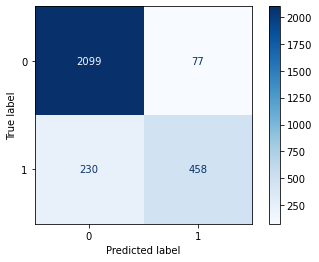

In [13]:
print_results("normal classification", model, prediction)


### Over Sampling (Random over Sampler)<a id='ROS'></a>  

In [14]:
over_pipeline = make_pipeline_imb(RandomOverSampler(random_state=42), ada(random_state=42))
over_model = over_pipeline.fit(X_train, y_train)
over_prediction = over_model.predict(X_test)

OVER classification
 Train Score :  86.13%
 Test Score  : 85.34%

 F1- Train Score: 73.31%
 F1- Test Score:  71.66%

66.88% of the songs were predicted correctly by the model.
77.18% of the Skipped songs were found.
The specificity is: 78.27%


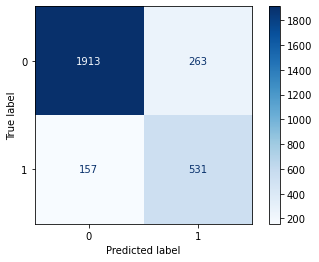

In [15]:
print_results("OVER classification", over_model, over_prediction)

### SMOTE (Synthetic Over Sampling)<a id='smote'></a>  

In [16]:
smote_pipeline = make_pipeline_imb(SMOTE(random_state=42), ada(random_state=42))
smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)


SMOTE classification
 Train Score :  81.33%
 Test Score  : 79.82%

 F1- Train Score: 65.56%
 F1- Test Score:  63.74%

56.07% of the songs were predicted correctly by the model.
73.84% of the Skipped songs were found.
The specificity is: 77.78%


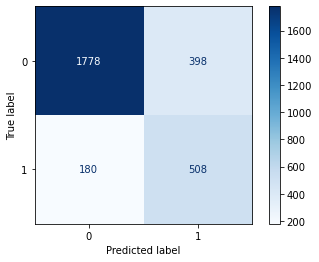

In [17]:
print_results("SMOTE classification",smote_model, smote_prediction)

### Near Miss (Under Sampling)<a id='under'></a>  

In [18]:
# build model with undersampling
under_pipeline = make_pipeline_imb(NearMiss(), ada(random_state=42))
under_model = under_pipeline.fit(X_train, y_train)
under_prediction = under_model.predict(X_test)

NearMiss classification
 Train Score :  66.67%
 Test Score  : 66.24%

 F1- Train Score: 56.60%
 F1- Test Score:  55.91%

40.73% of the songs were predicted correctly by the model.
89.10% of the Skipped songs were found.
The specificity is: 67.69%


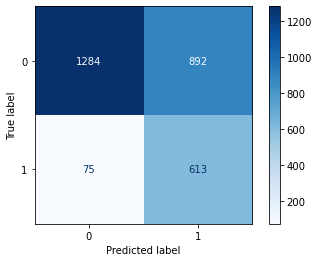

In [19]:
print_results("NearMiss classification", under_model, under_prediction)

### Classification Reports<a id='report'></a>  
A stacked view of all the models above classification report, using the sklearn imbalanced library to get insight into the specificity, geometric mean and index balanced accuracy.

In [20]:
class style:
   BOLD = '\033[1m'
   END = '\033[0m'
    
#https://stackoverflow.com/questions/24834876/how-can-i-make-text-bold-in-python

In [21]:
def reports(preds, header):
    print(style.BOLD + header + style.END)
    print(classification_report_imbalanced(y_test, preds, \
    target_names=['not_skipped', 'skipped']))
    print('')  

In [22]:
reports(prediction, 'Base AdaBoost Model')
reports(over_prediction, 'ROS Model')
reports(smote_prediction, 'SMOTE Model')
reports(under_prediction, 'Near Miss Model')

Base AdaBoost Model
                   pre       rec       spe        f1       geo       iba       sup

not_skipped       0.90      0.96      0.67      0.93      0.80      0.66      2176
    skipped       0.86      0.67      0.96      0.75      0.80      0.62       688

avg / total       0.89      0.89      0.74      0.89      0.80      0.65      2864


ROS Model
                   pre       rec       spe        f1       geo       iba       sup

not_skipped       0.92      0.88      0.77      0.90      0.82      0.69      2176
    skipped       0.67      0.77      0.88      0.72      0.82      0.67       688

avg / total       0.86      0.85      0.80      0.86      0.82      0.68      2864


SMOTE Model
                   pre       rec       spe        f1       geo       iba       sup

not_skipped       0.91      0.82      0.74      0.86      0.78      0.61      2176
    skipped       0.56      0.74      0.82      0.64      0.78      0.60       688

avg / total       0.82      0.80   

### Conclusion<a id='conc'></a>
Both Near Miss (undersampling) and Random over Sampling, increased the amount of skipped songs classified, however they both missclassified more not-skipped songs compared to the 'Base' Model. If I were to pick any of the sampling methods, it would be the ROS model, because although it lost 186 not skipped songs to gain 73 skipped songs, I believe that is a fair trade for not having to listen to songs that fall under the irritating category for me. However losing 815 not skipped songs to gain 155 skipped songs is too much (Near Miss)
<br> Next: [Attempting Neural Networks](./4.2_Model_RNN.ipynb)